In [ ]:
'''
this one is smart auto encoder, with padding
'''


In [10]:
import os
import cv2

In [11]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/'  #change dir to your project folder
# import os
# os.chdir(root_path)

In [60]:

from tensorflow.keras.datasets import cifar10


import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Cropping2D
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [13]:
import matplotlib.pyplot as plt

### 01 Get the data

In [14]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])

print(x_train.shape)

(50000, 32, 32)


In [15]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


In [16]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(50000, 32, 32) (50000, 1)
(10000, 32, 32) (10000, 1)


#### 01a Pad the train data with -1 for left hand side

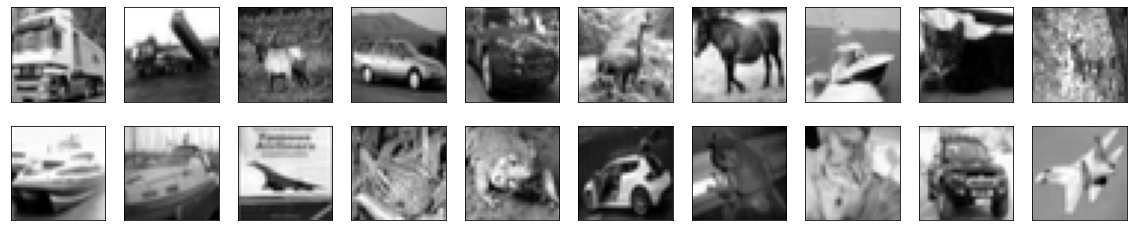

In [18]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.gray()
    plt.imshow(x_train[i])

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# a=[[1,2,3,4],
#    [5,6,7,8]]
# a=np.array(a)
# print(a.shape)
# col_padding=(2,2)
# row_padding=(2,2)
# np.pad(a,(col_padding,row_padding),'constant',constant_values=(-1))

In [19]:
perc=0.2
pad=int(perc*x_train[0].shape[1])
print("Number of rows on both sides = ",pad)
padding_val=127/255

denom=max(y_train)-min(y_train)
print(denom)



Number of rows on both sides =  6
[9]


In [20]:
def pad_single_channel(matrix,col_padding,row_padding,values):
    all_padded=[]
    for i in range(matrix.shape[0]):
        new_mat=np.pad(matrix[i],(col_padding,row_padding),'constant',constant_values=(values[i]))
        all_padded.append(new_mat)
    all_padded=np.array(all_padded)
    return all_padded
        

In [21]:
def pad_multi(matrix,col_padding, row_padding,values):
    '''
    matrix shape: count X rows X columns X channels
    col_padding: (left_padding, right_padding)
    row_padding: (up_padding, below_padding)
    value: value to pad with
    '''
#     b=np.pad(a, ((1,1), (1,1), (0,0)), mode='constant',constant_values=(9))

    all_padded=[]
    for i in range(matrix.shape[0]):
        new_padded=np.pad(matrix[i],(col_padding,row_padding,(0,0)),'constant',constant_values=(values[i]))
#         this_padded.append(np.pad(matrix[i][0],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][1],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][2],padding_length,'constant',constant_values=(values[i])))        
        all_padded.append(new_padded)
    all_padded=np.array(all_padded)
    return all_padded
        
        

In [22]:
values=[padding_val for i in range(x_train.shape[0])]
# x_train_left=pad_multi(x_train,(pad,pad),(pad,pad),values)

x_train_left=pad_single_channel(x_train,(pad,pad),(pad,pad),values)
rows=x_train_left.shape[1]
cols=x_train_left.shape[2]

x_train_left=x_train_left.reshape(len(x_train_left),rows,cols,1)
print(x_train_left.shape)
# x_train_left = np.reshape(x_train_left, (len(x_train_left), 30, 30, 1))


(50000, 44, 44, 1)


In [23]:
print(x_train[0].shape,x_train_left[0].shape)

(32, 32) (44, 44, 1)


#### 01b Pad the train data with y_values for right hand side

In [24]:
val=[y_train[i]/denom for i in range(y_train.shape[0])]
x_train_right=pad_single_channel(x_train,(pad,pad),(pad,pad),val)

rows=x_train_right.shape[1]
cols=x_train_right.shape[2]
print(rows,cols)


x_train_right=x_train_right.reshape(len(x_train_right),rows,cols,1)

print(x_train_right.shape)

44 44
(50000, 44, 44, 1)


#### 01c Pad the test data with padding_val for left hand side

In [25]:
values=[padding_val for i in range(x_test.shape[0])]
x_test_left=pad_single_channel(x_test,(pad,pad),(pad,pad),values)

rows=x_test_left.shape[1]
cols=x_test_left.shape[2]
print(rows,cols)


x_test_left=x_test_left.reshape(len(x_test_left),rows,cols,1)
print(x_test_left.shape)

44 44
(10000, 44, 44, 1)


#### 01d Pad the test data with y values for right hand side

In [26]:
x_test_right=[]
val=[y_test[i]/denom for i in range(y_test.shape[0])]
x_test_right=pad_single_channel(x_test,(pad,pad),(pad,pad),val)

rows=x_test_right.shape[1]
cols=x_test_right.shape[2]
print(rows,cols)

x_test_right=x_test_right.reshape(len(x_test_right),rows,cols,1)
print(x_test_right.shape)    

44 44
(10000, 44, 44, 1)


#### 01e Check the padding

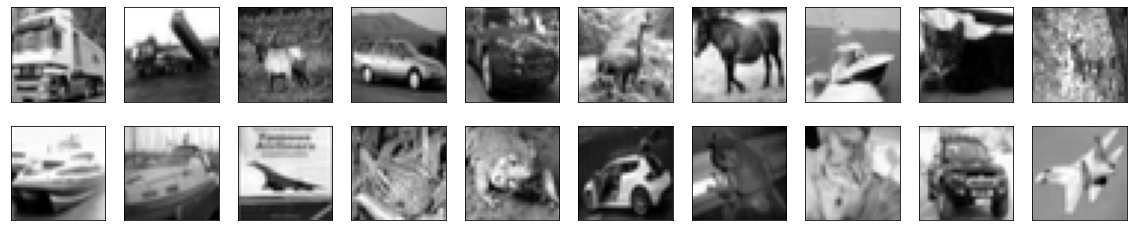

In [27]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


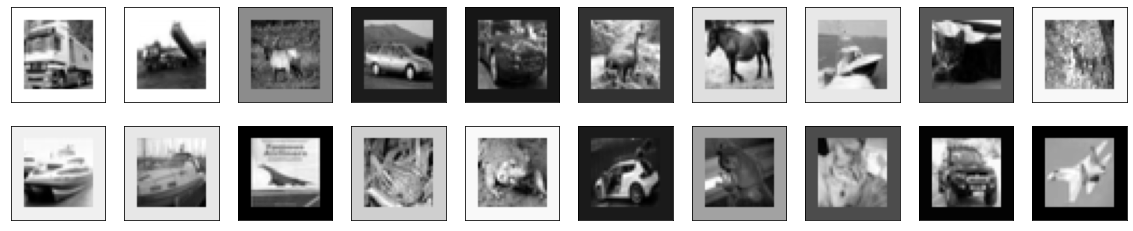

In [28]:
# after padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
#     print(x_train_right[i].shape)
    plt.imshow(x_train_right[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_right[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 02 Create and train the model

In [29]:
input_img = keras.Input(shape=x_train_left[0].shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded = Cropping2D(cropping=((1, 1), (1, 1)), data_format=None)(x) # this is the added step

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [30]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44, 44, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 8)         584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 22, 22, 8)         0     

In [32]:
from keras.callbacks import TensorBoard

history=autoencoder.fit(x_train_left, x_train_right,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_left, x_test_right))


Epoch 1/100
391/391 [==============================] - 16s 41ms/step - loss: 0.6378 - val_loss: 0.6360
Epoch 2/100
391/391 [==============================] - 15s 39ms/step - loss: 0.6350 - val_loss: 0.6342
Epoch 3/100
391/391 [==============================] - 16s 40ms/step - loss: 0.6339 - val_loss: 0.6332
Epoch 4/100
391/391 [==============================] - 16s 40ms/step - loss: 0.6327 - val_loss: 0.6323
Epoch 5/100
391/391 [==============================] - 15s 39ms/step - loss: 0.6322 - val_loss: 0.6326
Epoch 6/100
391/391 [==============================] - 16s 40ms/step - loss: 0.6316 - val_loss: 0.6312
Epoch 7/100
391/391 [==============================] - 16s 40ms/step - loss: 0.6309 - val_loss: 0.6329
Epoch 8/100
391/391 [==============================] - 16s 40ms/step - loss: 0.6308 - val_loss: 0.6304
Epoch 9/100
391/391 [==============================] - 16s 41ms/step - loss: 0.6306 - val_loss: 0.6301
Epoch 10/100
391/391 [==============================] - 16s 40ms/step - l

Epoch 80/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6257 - val_loss: 0.6260
Epoch 81/100
391/391 [==============================] - 23s 58ms/step - loss: 0.6257 - val_loss: 0.6262
Epoch 82/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6257 - val_loss: 0.6279
Epoch 83/100
391/391 [==============================] - 23s 60ms/step - loss: 0.6256 - val_loss: 0.6260
Epoch 84/100
391/391 [==============================] - 23s 60ms/step - loss: 0.6258 - val_loss: 0.6262
Epoch 85/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6256 - val_loss: 0.6264
Epoch 86/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6257 - val_loss: 0.6259
Epoch 87/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6257 - val_loss: 0.6257
Epoch 88/100
391/391 [==============================] - 23s 59ms/step - loss: 0.6256 - val_loss: 0.6255
Epoch 89/100
391/391 [==============================] - 23s 58ms

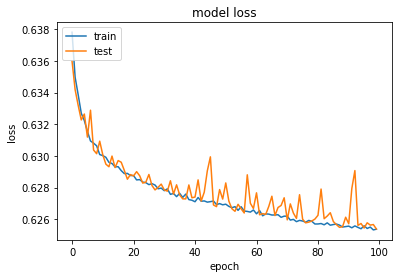

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

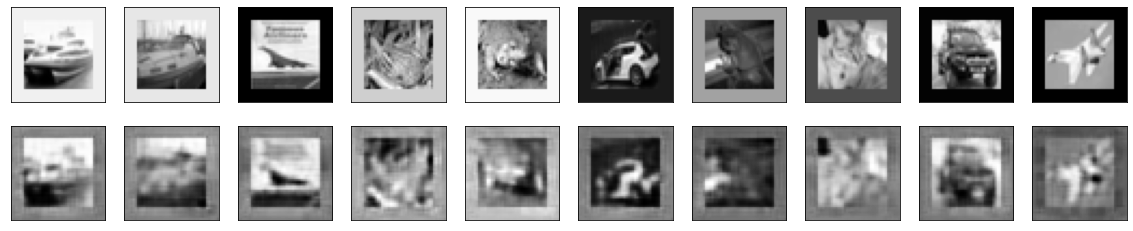

In [34]:
decoded_imgs = autoencoder.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [35]:
# decoded_imgs[0][9]

In [36]:
autoencoder.save("models/autoencoder_with_label.h")

INFO:tensorflow:Assets written to: models/autoencoder_with_label.h/assets


In [37]:
new_autoenc=load_model("models/autoencoder_with_label.h")

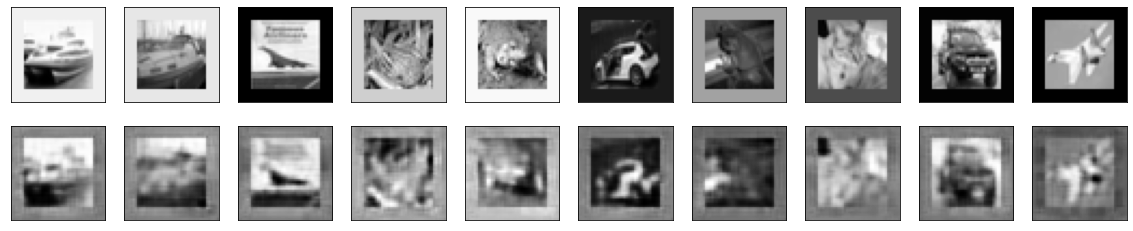

In [38]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


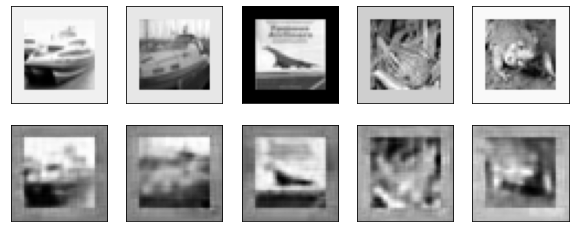

In [40]:
decoded_imgs = new_autoenc.predict(x_test_left)

n = 5
plt.figure(figsize=(10, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# plt.savefig("figures/decodedvsoriginal.svg")


### 03 Extract features and test with LogReg

In [41]:
encoder = Model(inputs=input_img, outputs=encoded)
encoder.save('models/encoder_with_label.h5')

In [42]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [43]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test_left)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode.shape)



(50000, 11, 11, 8)
Shape is  (50000, 968)
Shape of encoded flat (50000, 968)
(10000, 11, 11, 8)
Shape is  (10000, 968)
Shape of encoded flat (10000, 11, 11, 8)


In [44]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.4683


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 04 Extract features and Test with a CNN

In [45]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [46]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

(50000, 10) (10000, 10)


#### 04b Extract features using encoder

In [47]:
# load the model from file
encoder = load_model('models/encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test_left)
print("Shape of testing encoded images",x_test_encode.shape)


Shape of training encoded images (50000, 11, 11, 8)
Shape of testing encoded images (10000, 11, 11, 8)


In [48]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

(11, 11, 8) (11, 11, 8)


### 04c create a CNN that takes encoded image as input

In [61]:
def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    
# from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def define_model_VGG3(x_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=x_train[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [62]:
acc_list=[]
for i in range(10):
    model=get_model(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=100
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


313/313 [==============================] - 1s 4ms/step - loss: 2.3658 - accuracy: 0.5260
Accuracy is  0.5260000228881836
313/313 [==============================] - 1s 4ms/step - loss: 2.7837 - accuracy: 0.5219
Accuracy is  0.5218999981880188
313/313 [==============================] - 1s 4ms/step - loss: 2.7049 - accuracy: 0.5129
Accuracy is  0.5128999948501587
313/313 [==============================] - 1s 3ms/step - loss: 2.4545 - accuracy: 0.5225
Accuracy is  0.5224999785423279
313/313 [==============================] - 1s 4ms/step - loss: 3.0876 - accuracy: 0.5137
Accuracy is  0.513700008392334
313/313 [==============================] - 1s 3ms/step - loss: 3.2058 - accuracy: 0.5182
Accuracy is  0.5181999802589417
313/313 [==============================] - 1s 4ms/step - loss: 2.5394 - accuracy: 0.5135
Accuracy is  0.5134999752044678
313/313 [==============================] - 1s 4ms/step - loss: 3.0784 - accuracy: 0.5292
Accuracy is  0.52920001745224
313/313 [==========================

In [65]:
print(sum(acc_list)/len(acc_list))


0.5198599934577942


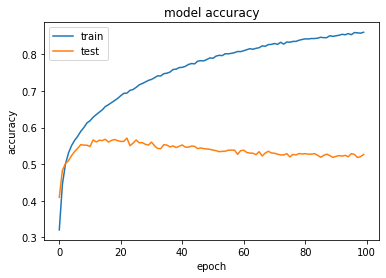

In [64]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
acc_list=[]
for i in range(20):
    model=get_model(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=40
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=0)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)